In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve 
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report

from xgboost import XGBClassifier as xgb


In [3]:
# plots' parameters with seaborn
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2, 'font_family': [u'times']})

In [4]:
# Load our dataset
df = pd.read_csv("data/character-predictions.csv")

In [5]:
seed = 42
np.random.seed(seed)


In [6]:
# Show first 5 rows
df.head(5)

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [7]:
# Lots of Nans
print(df.isna().sum())

S.No                    0
actual                  0
pred                    0
alive                   0
plod                    0
name                    0
title                1008
male                    0
culture              1269
dateOfBirth          1513
DateoFdeath          1502
mother               1925
father               1920
heir                 1923
house                 427
spouse               1670
book1                   0
book2                   0
book3                   0
book4                   0
book5                   0
isAliveMother        1925
isAliveFather        1920
isAliveHeir          1923
isAliveSpouse        1670
isMarried               0
isNoble                 0
age                  1513
numDeadRelations        0
boolDeadRelations       0
isPopular               0
popularity              0
isAlive                 0
dtype: int64


In [8]:
# weird mean why?
print(df["age"].mean())

-1293.5635103926097


In [9]:
# Negative Age
df["age"][df["age"] < 0]
# There are mistakes in the data Doreah is actually around 25 and Rhaego was never even born
print(df["name"][1684]) 
print(df["name"][1868])

Doreah
Rhaego


In [10]:
# Replace negative ages
df.loc[1684, "age"] = 25.0
df.loc[1868, "age"] = 0.0

/home/diego/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


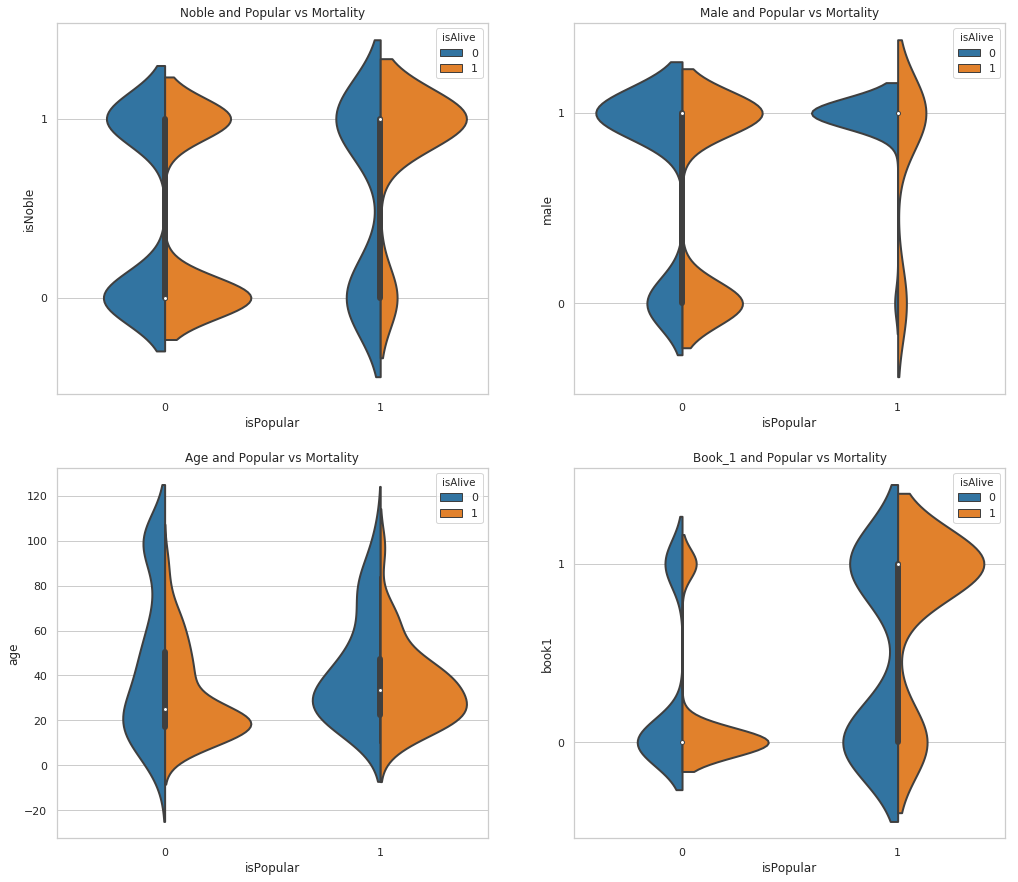

In [11]:
f,ax=plt.subplots(2,2,figsize=(17,15))
sns.violinplot("isPopular", "isNoble", hue="isAlive", data=df ,split=True, ax=ax[0, 0])
ax[0, 0].set_title('Noble and Popular vs Mortality')
ax[0, 0].set_yticks(range(2))

sns.violinplot("isPopular", "male", hue="isAlive", data=df ,split=True, ax=ax[0, 1])
ax[0, 1].set_title('Male and Popular vs Mortality')
ax[0, 1].set_yticks(range(2))

sns.violinplot("isPopular", "age", hue="isAlive", data=df ,split=True, ax=ax[1, 0])
ax[1, 0].set_title('Age and Popular vs Mortality')

sns.violinplot("isPopular", "book1", hue="isAlive", data=df ,split=True, ax=ax[1, 1])
ax[1, 1].set_title('Book_1 and Popular vs Mortality')
ax[1, 1].set_yticks(range(2))


plt.show()


In [12]:
# Drop columns 
drop = ["S.No", "pred", "alive", "plod", "name", "isAlive", "DateoFdeath"]
df.drop(drop, inplace=True, axis=1)

In [13]:
# Fill the nans we can
df["age"].fillna(df["age"].median(), inplace=True)
df["culture"].fillna("", inplace=True)

# Some nans values are nan because we dont know them so fill them with -1
df.fillna(value=-1, inplace=True)

In [14]:
# Lots of different names for one culture so lets group them up

cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
    'Ironborn': ['ironborn', 'ironmen'],
    'Mereen': ['meereen', 'meereenese'],
    'RiverLands': ['riverlands', 'rivermen'],
    'Vale': ['vale', 'valemen', 'vale mountain clans']
}

In [15]:
def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()

In [16]:
df.loc[:, "culture"] = [get_cult(x) for x in df["culture"]]

In [17]:
# Let's turn our strings features into one-hot encoded variables
df = pd.get_dummies(df)

In [18]:
x = df.iloc[:,1:].values
y = df.iloc[:, 0].values

In [19]:
# Let's build many different models to train with our data

kfold = KFold(n_splits=5, shuffle=True, random_state=seed) # split data into 5 equal groups for validation
mean=[]
std=[]

models = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=200, random_state=seed), 
          DecisionTreeClassifier(random_state=seed), svm.SVC(kernel='rbf', gamma='scale', random_state=seed), 
          KNeighborsClassifier()]

In [20]:
# Validate each model using K-fold cross validation
for model in models:
    result = cross_val_score(model, x, y, cv=kfold, scoring="accuracy", n_jobs=-1)
    mean.append(result)
    std.append(result)

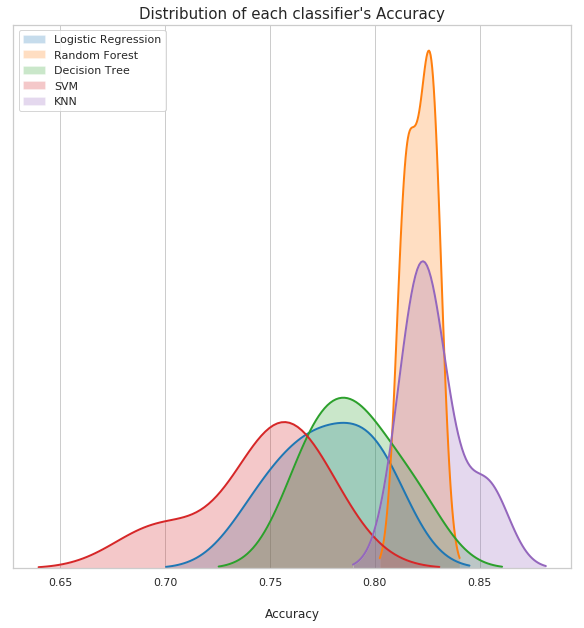

In [21]:
classifiers=['Logistic Regression', 'Random Forest', 'Decision Tree', 'SVM', 'KNN']

plt.figure(figsize=(10, 10))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribution of each classifier's Accuracy", fontsize=15)
plt.legend(classifiers)
plt.xlabel("Accuracy", labelpad=20)
plt.yticks([])

plt.show()

# It seems like Random Forest is the most reliable model when maximizing accuracy since its std is low and
# thus the accuracy values it yields do not vary much
# Our SVM perform much worse than expected let's see if we can improve them with some tuning.

# We will continue onward analyzing these 2 models more in depth:
# since the Random Forest shows the highest potential 
# and probably our svm can do much better if we 
# tune it's hyper-parameters a little

In [21]:
c = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel = ['rbf','linear']

hyper_parameters = {'kernel':kernel,'C':c,'gamma':gamma}

gs = GridSearchCV(estimator=svm.SVC(),param_grid=hyper_parameters,verbose=True, cv=kfold, n_jobs=-1)

# Find the best hyperparameters using grid-search
gs.fit(x,y)
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.8min finished


0.829393627954779
SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [22]:
# Indeed it seems like our svm can perform at least as well as our RandomForest

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=seed)

In [23]:
# Now that we know the best configuration we can use it to predict character deaths
svm_clf = svm.SVC(C=0.9, gamma=0.1, kernel='rbf', probability=True, random_state=seed)
rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=seed)

# Train our classfiers
svm_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [24]:
# Get the probability of assigning each sample to either class
svm_prob = svm_clf.predict_proba(x_test)
rf_prob = rf_clf.predict_proba(x_test)

# Get the actual predictions
svm_preds = np.argmax(svm_prob, axis=1)
rf_preds = np.argmax(rf_prob, axis=1)

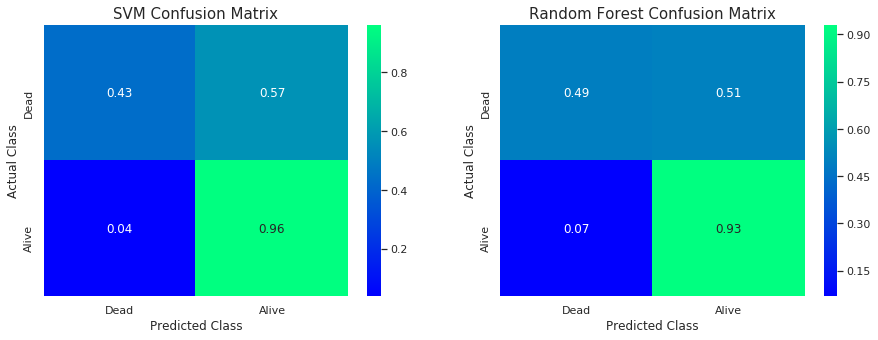

In [25]:
cm = confusion_matrix(y_test, svm_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm2 = confusion_matrix(y_test, rf_preds)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[: , np.newaxis]

classes = ["Dead", "Alive"]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("SVM Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[0]).set(xlabel="Predicted Class", ylabel="Actual Class")

ax[1].set_title("Random Forest Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[1]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")
plt.show()

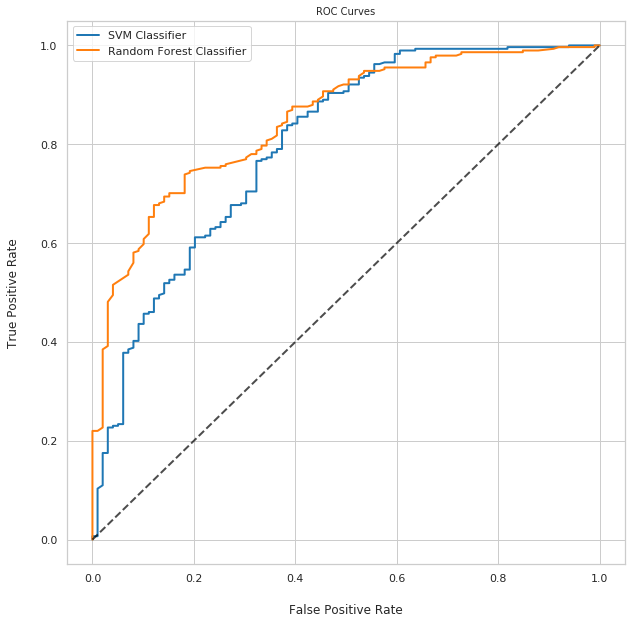

In [26]:
fig = plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(y_test, svm_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, rf_prob[:, 1])[:2])
plt.legend(["SVM Classifier", "Random Forest Classifier"], loc="upper left")
plt.plot((0., 1.), (0., 1.), "--k", alpha=.7) 
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate", labelpad=20)
plt.title("ROC Curves", fontsize=10)
plt.show()

In [27]:
# Our Classifiers struggles somewhat with negative examples
# Let's see if there is an imbalance in the number of sample for each class

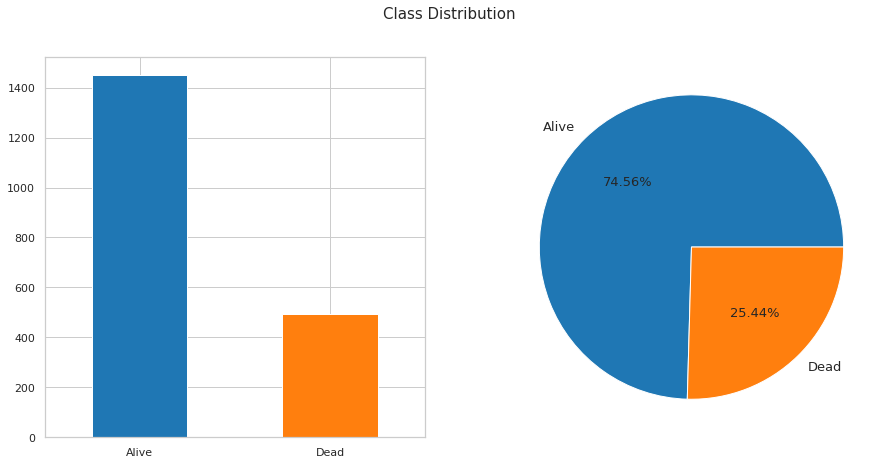

In [28]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("Class Distribution", fontsize = 15.)
df["actual"].value_counts().plot.bar(ax=ax[0], rot=0).set(xticklabels=["Alive", "Dead"])
df["actual"].value_counts().plot.pie(labels=("Alive", "Dead"), label="", autopct="%.2f%%", 
                                     fontsize=13., ax=ax[1])
plt.show()

In [38]:
# Let's use some downsampling to fix this
np.random.seed(seed)

tn_index = np.random.choice(np.where(y_train==0)[0], size=y_train[y_train==0].shape[0])
tp_index = np.random.choice(np.where(y_train==1)[0], size=tn_index.shape[0])

indexes = np.append(tn_index, tp_index)
np.random.shuffle(indexes)

ds_x_train = x_train[indexes]
ds_y_train = y_train[indexes]

In [39]:
%%capture  

#Let's train our models with our downsampled data
ds_svm_clf = svm.SVC(C=0.9, gamma=0.1, kernel='rbf', probability=True, random_state=seed, class_weight='balanced')
ds_rf_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=seed, class_weight='balanced')


ds_svm_clf.fit(ds_x_train, ds_y_train)
ds_rf_clf.fit(ds_x_train, ds_y_train)


In [40]:
ds_svm_prob = ds_svm_clf.predict_proba(x_test)
ds_rf_prob = ds_rf_clf.predict_proba(x_test)

ds_svm_preds = np.argmax(ds_svm_prob, axis=1)
ds_rf_preds = np.argmax(ds_rf_prob, axis=1)

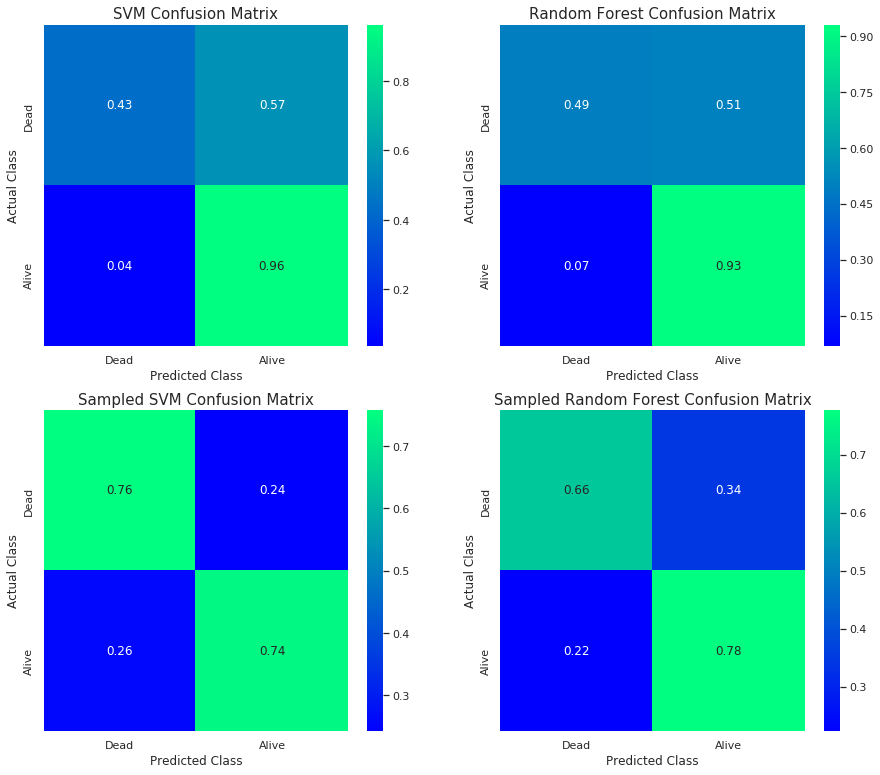

In [41]:
cm3 = confusion_matrix(y_test, ds_svm_preds)
cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
cm4 = confusion_matrix(y_test, ds_rf_preds)
cm4 = cm4.astype('float') / cm4.sum(axis=1)[:, np.newaxis]


f, ax = plt.subplots(2, 2, figsize=(15, 13))
ax[0, 0].set_title("SVM Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[0, 0]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")

ax[0, 1].set_title("Random Forest Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[0, 1]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")
ax[1, 0].set_title("Sampled SVM Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm3, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[1, 0]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")
ax[1, 1].set_title("Sampled Random Forest Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm4, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[1, 1]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")

plt.show()

In [42]:
# Great now our both of our classifier classify negative samples much better
# Explain that both classes are important, precision, recall

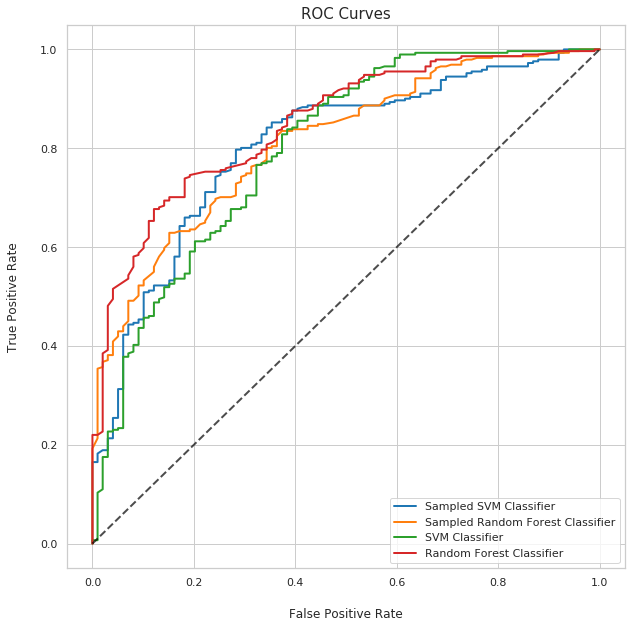

In [43]:
fig = plt.figure(figsize=(10, 10))

plt.plot(*roc_curve(y_test, ds_svm_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, ds_rf_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, svm_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, rf_prob[: ,1])[:2])

legend = ["Sampled SVM Classifier", "Sampled Random Forest Classifier", 
          "SVM Classifier", "Random Forest Classifier"]

plt.legend(legend, loc="lower right")
plt.plot((0., 1.), (0., 1.), "--k", alpha=.7) 
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate", labelpad=20)
plt.title("ROC Curves", fontsize=15)
plt.show()

In [44]:
# Lets take a look at the score card  for them
print("SVM Classifier Performance")
print("=" * 27)
print(classification_report(y_test, svm_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, svm_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, svm_prob[:, 1])))
print("\n")

print("Sampled SVM Classifier Performance")
print("=" * 37)
print(classification_report(y_test, ds_svm_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, ds_svm_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, ds_svm_prob[:, 1])))
print("\n")

print("Random Forest Classifier Performance")
print("=" * 37)
print(classification_report(y_test, rf_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, rf_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, rf_prob[:, 1])))
print("\n")

print("Sampled RF Classifier Performance")
print("=" * 37)
print(classification_report(y_test, ds_rf_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, ds_rf_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, ds_rf_prob[:, 1])))
print("\n")

SVM Classifier Performance
              precision    recall  f1-score   support

        Dead       0.80      0.43      0.56        99
       Alive       0.83      0.96      0.89       291

   micro avg       0.83      0.83      0.83       390
   macro avg       0.81      0.70      0.73       390
weighted avg       0.82      0.83      0.81       390

Accuracy: 0.83
AUC score: 0.80


Sampled SVM Classifier Performance
              precision    recall  f1-score   support

        Dead       0.50      0.76      0.60        99
       Alive       0.90      0.74      0.81       291

   micro avg       0.75      0.75      0.75       390
   macro avg       0.70      0.75      0.71       390
weighted avg       0.80      0.75      0.76       390

Accuracy: 0.75
AUC score: 0.80


Random Forest Classifier Performance
              precision    recall  f1-score   support

        Dead       0.71      0.49      0.58        99
       Alive       0.84      0.93      0.89       291

   micro avg     

In [36]:
# Despite our efforts to balance the classes it seems like the
# Imbalanced Random Forest performs better
# Let's see if xgboost can beat the rest of the classifiers as it tends to do

In [256]:
learning_rate = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
n_estimators = [100, 200, 300, 400]
max_depth = [2, 3, 4]

hyper_parameters = {'learning_rate':learning_rate, 'n_estimators':n_estimators, 
                    'base_estimator': base_estimator, 'max_depth:' max_depth}

gs = GridSearchCV(estimator=xgb(random_state=seed, n_jobs=-1), param_grid=hyper_parameters,
                  verbose=True, cv=kfold, n_jobs=-1)

# Find the best hyperparameters using grid-search
gs.fit(x_test, y_test)
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/diego/.local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
preds_prob = clf.predict_proba(x_test)
preds = np.argmax(preds_prob, axis=1)

In [ ]:
print("Adaboost Classifier Performance")
print("=" * 37)
print(classification_report(y_test, preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, preds_prob[:, 1])))